In [1]:
import shutil

shutil.rmtree('brain_tumor_data')

FileNotFoundError: [Errno 2] No such file or directory: 'brain_tumor_data'

In [2]:
from google.colab import files
import zipfile
import os
from pathlib import Path
import shutil

# Upload ZIP files
uploaded = files.upload()  # Expect images.zip and labels.zip

# Define paths
base_path = Path("brain_tumor_data")
images_path = base_path / "images"
labels_path = base_path / "labels"

# Create folders
images_path.mkdir(parents=True, exist_ok=True)
labels_path.mkdir(parents=True, exist_ok=True)

# Function to unzip and flatten
def unzip_and_flatten(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Move all files to root of extract_to
    for root, _, files in os.walk(extract_to):
        for file in files:
            src = os.path.join(root, file)
            dst = os.path.join(extract_to, file)
            if src != dst:
                shutil.move(src, dst)

    # Remove subdirectories
    for item in os.listdir(extract_to):
        item_path = os.path.join(extract_to, item)
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)

# Unzip uploaded files
unzip_and_flatten("images.zip", images_path)
unzip_and_flatten("labels.zip", labels_path)


Saving labels.zip to labels.zip
Saving images.zip to images.zip


In [3]:
import pandas as pd

# List image and label files
image_files = list(images_path.glob("*"))
label_files = list(labels_path.glob("*"))

# Match by base filename (without extension)
def get_base_filename(path):
    return path.stem

image_map = {get_base_filename(p): p for p in image_files}
label_map = {get_base_filename(p): p for p in label_files}

matched_data = []
for base_name, label_path in label_map.items():
    if base_name in image_map:
        with open(label_path, 'r') as f:
            content = f.read().strip()
            if content:
                first_class = int(content.split('\n')[0].split()[0])
                matched_data.append({
                    "filename": base_name,
                    "image_path": str(image_map[base_name]),
                    "label_path": str(label_path),
                    "has_tumor": first_class == 1
                })

# Convert to DataFrame
matched_df = pd.DataFrame(matched_data)

# Count tumor vs no tumor
tumor_count = matched_df["has_tumor"].sum()
no_tumor_count = len(matched_df) - tumor_count

print(f"Tumor Images: {tumor_count}")
print(f"No Tumor Images: {no_tumor_count}")
print(f"Total Matched: {len(matched_df)}")

# Optional: preview
matched_df.head()


Tumor Images: 459
No Tumor Images: 419
Total Matched: 878


,filename,image_path,label_path,has_tumor
0,00313_126,brain_tumor_data/images/00313_126.jpg,brain_tumor_data/labels/00313_126.txt,True
1,97 (2),brain_tumor_data/images/97 (2).jpg,brain_tumor_data/labels/97 (2).txt,True
2,00090_112,brain_tumor_data/images/00090_112.jpg,brain_tumor_data/labels/00090_112.txt,False
3,00172_108,brain_tumor_data/images/00172_108.jpg,brain_tumor_data/labels/00172_108.txt,False
4,00148_19,brain_tumor_data/images/00148_19.jpg,brain_tumor_data/labels/00148_19.txt,False


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assume matched_df is already created
# Stratified split to maintain tumor/no-tumor ratio
train_df, test_df = train_test_split(
    matched_df,
    test_size=0.2,
    stratify=matched_df["has_tumor"],
    random_state=42
)

# Reset index for convenience
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print summary
print(f"Training Set: {len(train_df)} images")
print(f"  - Tumor: {train_df['has_tumor'].sum()}")
print(f"Test Set: {len(test_df)} images")
print(f"  - Tumor: {test_df['has_tumor'].sum()}")


Training Set: 702 images
  - Tumor: 367
Test Set: 176 images
  - Tumor: 92


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4838 - auc: 0.5000 - loss: 0.7372 - precision: 0.1479 - recall: 0.0437

44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 409ms/step - accuracy: 0.4834 - auc: 0.5000 - loss: 0.7371 - precision: 0.1552 - recall: 0.0483 - val_accuracy: 0.4716 - val_auc: 0.5189 - val_loss: 0.7156 - val_precision: 0.4000 - val_recall: 0.0217
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5462 - auc: 0.5000 - loss: 0.7088 - precision: 0.5468 - recall: 0.9705

44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.5453 - auc: 0.5000 - loss: 0.7088 - precision: 0.5462 - recall: 0.9660 - val_accuracy: 0.4716 - val_auc: 0.5092 - val_loss: 0.7013 - val_precision: 0.3333 - val_recall: 0.0109
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4752 - auc: 0.5000 - loss: 0.6981 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.4753 - auc: 0.5000 - loss: 0.6981 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5246 - val_loss: 0.6971 - val_precision: 0.5000 - val_recall: 0.0109
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.4892 - auc: 0.5000 - loss: 0.6951 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.4890 - auc: 0.5000 - loss: 0.6951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5144 - val_loss: 0.6965 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.4542 - auc: 0.5000 - loss: 0.6924 - precision: 0.3445 - recall: 0.1750 - val_accuracy: 0.4773 - val_auc: 0.5271 - val_loss: 0.6966 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4497 - auc: 0.5000 - loss: 0.6924 - precision: 0.2571 - recall: 0.1457

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.4498 - auc: 0.5000 - loss: 0.6924 - precision: 0.2616 - recall: 0.1483 - val_accuracy: 0.4773 - val_auc: 0.5140 - val_loss: 0.6963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4860 - auc: 0.5000 - loss: 0.6937 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.4858 - auc: 0.5000 - loss: 0.6937 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5157 - val_loss: 0.6956 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.4649 - auc: 0.5000 - loss: 0.6924 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.4652 - auc: 0.5000 - loss: 0.6924 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.4999 - val_loss: 0.6948 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4741 - auc: 0.5000 - loss: 0.6930 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.4741 - auc: 0.5000 - loss: 0.6930 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5255 - val_loss: 0.6941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.4784 - auc: 0.5000 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.4784 - auc: 0.5000 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.4733 - val_loss: 0.6936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4881 - auc: 0.5000 - loss: 0.6938 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.4879 - auc: 0.5000 - loss: 0.6938 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5160 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4706 - auc: 0.5000 - loss: 0.6927 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.4707 - auc: 0.5000 - loss: 0.6927 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4749 - auc: 0.5000 - loss: 0.6930 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.4749 - auc: 0.5000 - loss: 0.6930 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.4872 - auc: 0.5000 - loss: 0.6938 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.4870 - auc: 0.5000 - loss: 0.6938 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4710 - auc: 0.5000 - loss: 0.6928 - precision: 0.0000e+00 - recall: 0.0000e+00

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.4711 - auc: 0.5000 - loss: 0.6928 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4571 - auc: 0.5000 - loss: 0.6922 - precision: 0.1649 - recall: 0.0632

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.4571 - auc: 0.5000 - loss: 0.6922 - precision: 0.1714 - recall: 0.0666 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.4786 - auc: 0.5000 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.4775 - auc: 0.5000 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.4904 - auc: 0.5000 - loss: 0.6940 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.4638 - auc: 0.5000 - loss: 0.6923 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 23/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.4683 - auc: 0.5000 - loss: 0.6926 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.4735 - auc: 0.5000 - loss: 0.6929 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4587 - auc: 0.5000 - loss: 0.6916 - precision: 0.3124 - recall: 0.2409

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.4591 - auc: 0.5000 - loss: 0.6917 - precision: 0.3165 - recall: 0.2486 - val_accuracy: 0.5227 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.5227 - val_recall: 1.0000
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.4852 - auc: 0.5000 - loss: 0.6925 - precision: 0.5152 - recall: 0.5399 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 27/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.5142 - auc: 0.5000 - loss: 0.6955 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.4797 - auc: 0.5000 - loss: 0.6933 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4773 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+

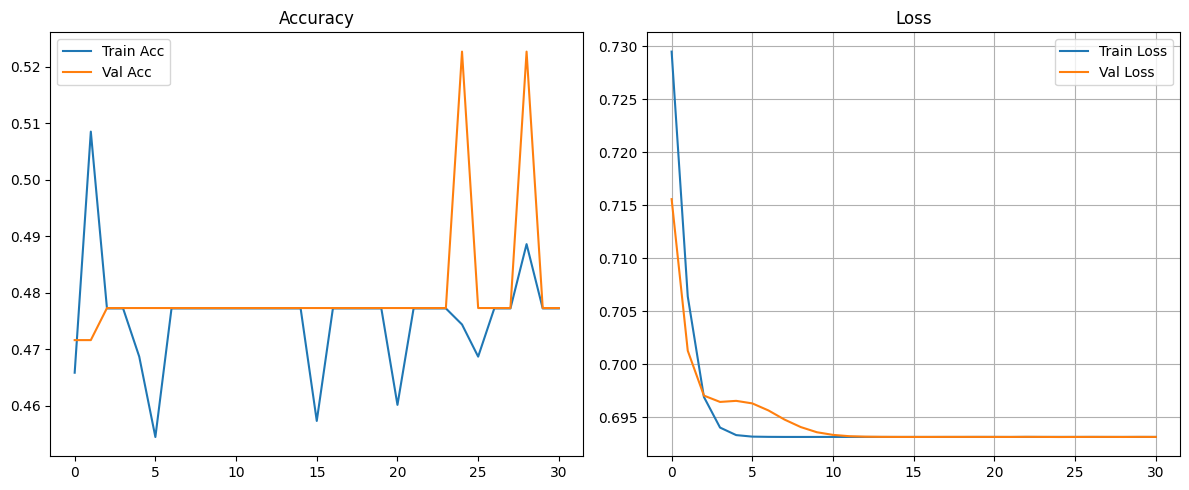

In [ ]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, class_weight
from tensorflow.keras import layers, models, regularizers, callbacks
import tensorflow as tf


IMG_SIZE = 224
input_shape = (IMG_SIZE, IMG_SIZE, 3)

#  Load image function
def load_image(path):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

#Load data
X_train = np.array([load_image(p) for p in train_df["image_path"]], dtype=np.float32)
y_train = np.array(train_df["has_tumor"]).astype(np.uint8)

X_test = np.array([load_image(p) for p in test_df["image_path"]], dtype=np.float32)
y_test = np.array(test_df["has_tumor"]).astype(np.uint8)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

#Compute class weights (to fix imbalance)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

#ImageDataGenerators
train_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
val_aug = tf.keras.preprocessing.image.ImageDataGenerator()

train_gen = train_aug.flow(X_train, y_train, batch_size=16, shuffle=True)
val_gen = val_aug.flow(X_test, y_test, batch_size=16, shuffle=False)

# Build deeper CNN with regularization
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile with additional metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    callbacks.ModelCheckpoint("improved_cnn_best.h5", save_best_only=True)
]

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=cb,
    class_weight=class_weights
)

# Evaluate
loss, acc, auc, precision, recall = model.evaluate(val_gen)
print(f"Test Accuracy: {acc*100:.2f}% | AUC: {auc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}")

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
